In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from adjustText import adjust_text
from statsmodels.stats.multitest import fdrcorrection, multipletests
import matplotlib.colors as mcolors
from gseapy import barplot, dotplot
import gseapy as gp

In [4]:
model = '/Users/connormullins/Excel sheets/Model.csv'
osm = '/Users/connormullins/Excel sheets/OmicsSomaticMutations.csv'
effect = '/Users/connormullins/Excel sheets/CRISPRGeneEffect.csv'

In [729]:
model_df = pd.read_csv(model, header=0, index_col=0)
osm_df = pd.read_csv(osm, header=0, low_memory=False)
effect_df = pd.read_csv(effect, header=0, index_col=0)

In [730]:
cancer_type = "Colorectal Adenocarcinoma"
protein = "KRAS"
gene_change = "p.G12D"

In [731]:
#filter to get only mutated genes
cancer_filter = model_df[model_df["OncotreePrimaryDisease"] == cancer_type]
osm_filter_pie = cancer_filter.merge(osm_df, on=['ModelID'], how='inner')
protein_filter = osm_filter_pie[(osm_filter_pie['HugoSymbol'] == protein)]
protein_change_filter = protein_filter[(protein_filter['ProteinChange']== gene_change)]
osm_filter_pie.set_index('ModelID')
protein_change_filter = protein_change_filter.filter(['ModelID'])

In [732]:
#retrieve wt cell lines-- have cancer but not gene mutation specified
# concat ModelIDs of protein_filter and osm_df-- drop duplicates of osm_df and keep first, then drop duplicates with protein_filter
osm_df = osm_df.filter(['ModelID'])
osm_df = osm_df.drop_duplicates(keep = 'first')
protein_filter = protein_filter.filter(['ModelID'])
wt_and_mutant = pd.concat([protein_filter, osm_df])
wt_gene = wt_and_mutant.drop_duplicates(keep = False)

In [733]:
effect_mutant = protein_change_filter.merge(effect_df, on = ['ModelID'], how = 'inner')
effect_mutant = effect_mutant.set_index('ModelID')

effect_wt = wt_gene.merge(effect_df, on = ['ModelID'], how = 'inner')
effect_wt = effect_wt.set_index('ModelID')

In [734]:
_, p_value = scipy.stats.ttest_ind(effect_mutant, effect_wt)

In [735]:
pvalue_df = pd.DataFrame(p_value)
pvalue_df = pvalue_df.set_index(effect_df.columns)
pvalue_df = pvalue_df.rename(columns = {0 : 'p-value'})
#use mean gene effect to rank
pvalue_df['mean gene effect'] = effect_mutant.mean(axis = 0)

In [736]:
sig_pv = pvalue_df[pvalue_df['p-value'] < 0.05]
sig_pv = sig_pv.reset_index()
sig_pv = sig_pv.sort_values('p-value', ascending=True)
sig_pv['gene name'] = sig_pv['index'].apply(lambda x: x.split(' ')[0])
#sig_pv['gene name'] = sig_pv['index'].str.extract(r'\((\d+)\)')

In [737]:
rnk = pd.DataFrame()
rnk['gene'] = sig_pv['gene name']
rnk['gene'] = rnk['gene'].str.upper()

rnk['score'] = sig_pv['mean gene effect']

wt_stuff = pd.DataFrame()
wt_stuff['scores'] = effect_mutant.mean(axis = 0, skipna=True, numeric_only=True)
wt_stuff = wt_stuff.set_index(effect_df.columns)
wt_stuff = wt_stuff.reset_index()

wt_stuff['index'] = wt_stuff['index'].apply(lambda x: x.split(' ')[0])

In [738]:
gmt = gp.read_gmt(path = '/Users/connormullins/Downloads/c2.cp.pid.v2024.1.Hs.symbols.gmt')

In [739]:
enr = gp.prerank(rnk=rnk,
                     gene_sets=gmt,
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000,
                     outdir=None,
                     seed=6,
                     verbose=True,
                    )

2024-10-18 10:27:46,654 [INFO] Parsing data files for GSEA.............................
2024-10-18 10:27:46,656 [INFO] 0124 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-10-18 10:27:46,657 [INFO] 0072 gene_sets used for further statistical testing.....
2024-10-18 10:27:46,657 [INFO] Start to run GSEA...Might take a while..................
2024-10-18 10:27:46,859 [INFO] Congratulations. GSEApy runs successfully................



In [740]:
gsea_mut = pd.DataFrame(enr.res2d)

In [741]:
mut_pathways_and_scores = pd.DataFrame()

for term in gsea_mut:
    mut_pathways_and_scores['pathway'] = gsea_mut['Term']
    mut_pathways_and_scores['MUT NES'] = gsea_mut['NES']

In [742]:
wt_enr = gp.prerank(rnk=wt_stuff,
                     gene_sets=gmt,
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000,
                     outdir=None,
                     seed=6,
                     verbose=True,
                    )

2024-10-18 10:27:46,880 [WARNING] Input gene rankings contains NA values(gene name and ranking value), drop them all!
2024-10-18 10:27:46,894 [INFO] Parsing data files for GSEA.............................
2024-10-18 10:27:46,897 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-10-18 10:27:46,898 [INFO] 0196 gene_sets used for further statistical testing.....
2024-10-18 10:27:46,898 [INFO] Start to run GSEA...Might take a while..................
2024-10-18 10:27:51,410 [INFO] Congratulations. GSEApy runs successfully................



In [743]:
gsea_wt = pd.DataFrame(wt_enr.res2d)

In [744]:
wt_pathways_and_scores = pd.DataFrame()

for term in gsea_wt:
    wt_pathways_and_scores['pathway'] = gsea_wt['Term']
    wt_pathways_and_scores['WT NES'] = gsea_wt['NES']

In [745]:
enriched_shared = pd.DataFrame()
enriched_shared = mut_pathways_and_scores.merge(wt_pathways_and_scores, how = 'inner', on = 'pathway')
enriched_shared['difference'] = abs(enriched_shared['MUT NES'] - enriched_shared['WT NES'])

In [746]:
enriched_shared = enriched_shared.sort_values('difference', ascending=False).head(10)

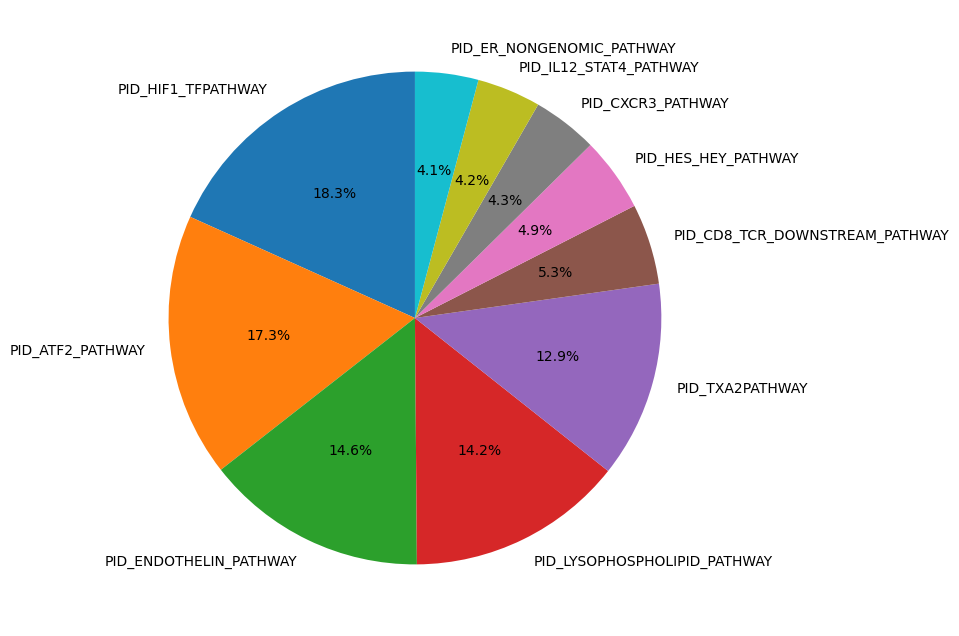

In [747]:
plt.figure(figsize=(8, 8))
plt.pie(enriched_shared['difference'], labels=enriched_shared['pathway'], autopct='%1.1f%%', startangle=90)
plt.show()